## 전체 딥러닝 플로우 구현 해보기

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

#### 데이터 Load 와 전처리

In [2]:
import torch
from torchvision import datasets, transforms # 이미지 처리

In [3]:
batch_size = 32

# 데이터 부르기
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('dataset/',
                   train=True, download=True, # 로컬 환경에 데이터가 없다면 다운로드하라
                   transform=transforms.Compose([ # 가져올 때 미리 아래와 같이 전처리해서 가져오겠다
                       transforms.ToTensor(),
                       transforms.Normalize(mean=(0.5,), std=(0.5,)) # mean이 0.5이고 std가 0.5가 되는 분포가 되도록 정규화시켜라.
                                                                    # 튜플 형태로 넣어주어야함
                   ])),
    batch_size=batch_size,
    shuffle=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 81165782.78it/s]


Extracting dataset/MNIST/raw/train-images-idx3-ubyte.gz to dataset/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 77353572.05it/s]

Extracting dataset/MNIST/raw/train-labels-idx1-ubyte.gz to dataset/MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 20808622.65it/s]


Extracting dataset/MNIST/raw/t10k-images-idx3-ubyte.gz to dataset/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 14756412.68it/s]


Extracting dataset/MNIST/raw/t10k-labels-idx1-ubyte.gz to dataset/MNIST/raw



In [4]:
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('dataset/',
                   train=False, # 로컬 환경에 데이터가 없다면 다운로드하라
                   transform=transforms.Compose([ # 가져올 때 미리 아래와 같이 전처리해서 가져오겠다
                       transforms.ToTensor(),
                       transforms.Normalize(mean=(0.5,), std=(0.5,)) # mean이 0.5이고 std가 0.5가 되는 분포가 되도록 정규화시켜라.
                                                                    # 튜플 형태로 넣어주어야함
                   ])),
    batch_size=batch_size,
    shuffle=False)

#### 데이터 확인

PyTorch에서는 TF와 이미지를 표현하는데 있어서 차이점이 있음.

- TF - (batch, height, width, channel)
- PyTorch - (batch, channel, height, width)

In [5]:
images, labels = next(iter(train_loader))
images.shape, images.dtype

(torch.Size([32, 1, 28, 28]), torch.float32)

In [6]:
images[0].shape

torch.Size([1, 28, 28])

In [7]:
torch_image = torch.squeeze(images[0])
torch_image.shape

torch.Size([28, 28])

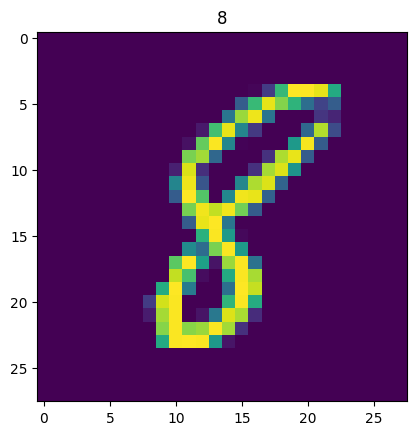

In [8]:
image = torch_image.numpy()
label = labels[0].numpy()

plt.title(label)
plt.imshow(image)
plt.show()

----

### 모델 정의

In [10]:
from torch import nn # 학습할 파라미터가 있는 것들 # conv2d
import torch.nn.functional as F # 학습할 파라미터가 없는 것들 # maxpool, relu

nn.Module 를 상속 받아서 주로 사용

In [11]:
class Net(nn.Module):
    def __init__(self): # forward에서 사용되는 레이어, 파라미터 정의
        super(Net, self).__init__()
                              # tf에서는 output만 넣어주었다면
                              # pytorch에서는 input과 output을 같이 정의해줌
                              # input, output
        self.conv1 = nn.Conv2d(1, 20, 5, 1)
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        self.fc1 = nn.Linear(4*4*50, 500)
        self.fc2 = nn.Linear(500, 10)

    def forward(self, x): # 실제 연산
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4*4*50)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Net().to(device) # 모델을 device로 넘겨줌

In [13]:
print(model)

Net(
  (conv1): Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(20, 50, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=800, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
)


### 학습 로직

PyTorch에서는 model을 Training 모드로 변경 후 Training 할 수 있다.

- epoch
  - batch
    - model
    - loss
    - grad
    - model update

#### Training mode로 !

In [14]:
model.train()

Net(
  (conv1): Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(20, 50, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=800, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
)

#### Evaluation mode로 !

In [15]:
model.eval()

Net(
  (conv1): Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(20, 50, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=800, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
)

In [17]:
x, y = next(iter(train_loader))
x.shape, y.shape # 타겟 데이터 원핫인코딩 안되어있음

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

In [19]:
import torch.optim as optim

opt = optim.SGD(model.parameters(), lr=0.003)

for epoch in range(1):
  # 학습
  model.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    data, target = data.to(device) , target.to(device) # 데이터 device로 보내기

    output = model(data)
    loss = F.nll_loss(output, target)
          # 지금 원핫인코딩이 안 되어있는 상태이다.
          # tf 에서는 SparseCategoricalCrossentropy loss를 사용해
          # 원핫 인코딩이 안 되어있는 상태에서도 사용 가능했는데
          # 이를 torch에서 구현하려면 log softmax와 nll_loss를 조합하면 됨.

    loss.backward()

    opt.step() # 업데이트

    print('batch {} loss : {}'.format(batch_idx, loss.item()))

    opt.zero_grad() # 초기화

  # 평가
  model.eval()

  test_loss = 0

  with torch.no_grad():
    for data, target in test_loader:
      output = model(data)
      test_loss += F.nll_loss(output, target).item()
  # 한 epoch 마다 배치 데이터의 평균 loss 값
  test_loss /= (len(test_loader.dataset) // 32)

  print('Epoch {} test loss : {}'.format(epoch, test_loss))

batch 0 loss : 0.1982896775007248
batch 1 loss : 0.36626195907592773
batch 2 loss : 0.456458181142807
batch 3 loss : 0.2238730788230896
batch 4 loss : 0.3161660134792328
batch 5 loss : 0.2452026754617691
batch 6 loss : 0.4035956859588623
batch 7 loss : 0.12090227007865906
batch 8 loss : 0.253180593252182
batch 9 loss : 0.29156729578971863
batch 10 loss : 0.17646965384483337
batch 11 loss : 0.3460148274898529
batch 12 loss : 0.3712300658226013
batch 13 loss : 0.18758127093315125
batch 14 loss : 0.19380304217338562
batch 15 loss : 0.23614680767059326
batch 16 loss : 0.27114248275756836
batch 17 loss : 0.32340842485427856
batch 18 loss : 0.22006502747535706
batch 19 loss : 0.5084657073020935
batch 20 loss : 0.1519293487071991
batch 21 loss : 0.10107065737247467
batch 22 loss : 0.17283248901367188
batch 23 loss : 0.16541551053524017
batch 24 loss : 0.3503643572330475
batch 25 loss : 0.28879600763320923
batch 26 loss : 0.3268868923187256
batch 27 loss : 0.4263725280761719
batch 28 loss : 0.

-----

### Evaluation

- autograd engine, 즉 backpropagatin이나 gradient 계산 등을 꺼서 memory usage를 줄이고 속도를 높임